In [1]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import logging
# Set logging level to suppress warnings
logging.basicConfig(level=logging.ERROR)

# Load Dataset & Feature Selection

In [3]:
# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

df.head()

/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_98973/3691372692.py:2: DtypeWarning: Columns (1,10,18,21,22,24,25,26,27,28,33,35,39,44,45,46,203,205,207) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,B,Br,Cl,K,Sr,Na,Li
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98


## Binning

In [4]:
bins = [0, 70, 200, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=True)
df.head()

,B,Br,Cl,K,Sr,Na,Li,Li_class
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50,low
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30,low
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98,low
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10,low
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98,low


In [5]:
# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)
df.head()

,B,Br,Cl,K,Sr,Na,Li,Li_class
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50,0
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30,0
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98,0
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10,0
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98,0


In [6]:
# Preserve the Na_class for later (it must stay based on the original 'Na' values)
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Li' and 'Li_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na']].apply(np.log10)

# Reassign 'Na_class' back to the dataframe to keep it intact
df['Li_class'] = li_class

# Drop 'Na' column since it's no longer needed
df = df.drop(columns='Li')
original_df = original_df.drop(columns=['Li_class'])

## Rebalancing

Li_class
0    1555
1     176
2      70
Name: count, dtype: int64


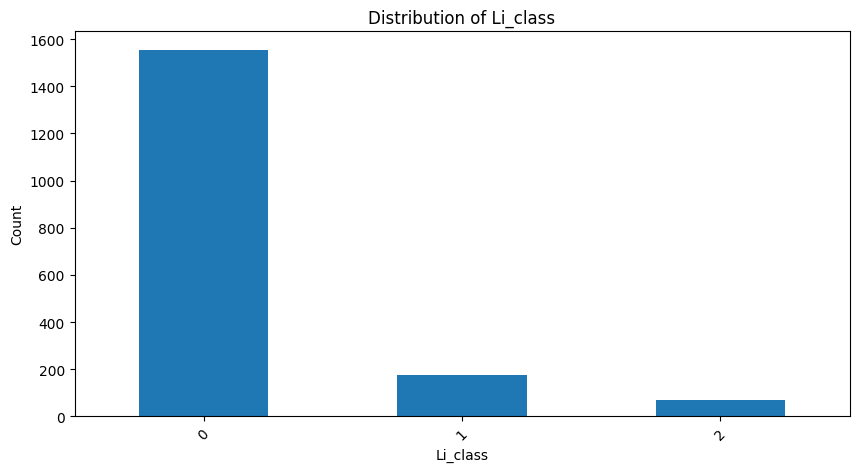

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv("your_data.csv")

# Count occurrences of each class
class_counts = df['Li_class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.xlabel("Li_class")
plt.ylabel("Count")
plt.title("Distribution of Li_class")
plt.xticks(rotation=45)
plt.show()


In [8]:
# !pip install ImbalancedDatasetSampler

In [9]:
from torchsampler import ImbalancedDatasetSampler
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

In [10]:
from torch.utils.data import Dataset
from torchsampler import ImbalancedDatasetSampler
import torch

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = df.drop('Li_class', axis=1).values
        self.labels = df['Li_class'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

    def get_labels(self):
        return self.labels

custom_dataset = CustomDataset(df)

In [11]:
from torch.utils.data import DataLoader

sampler = ImbalancedDatasetSampler(custom_dataset)
balanced_loader = DataLoader(custom_dataset, sampler=sampler, batch_size=len(custom_dataset))

In [12]:
balanced_data = next(iter(balanced_loader))
balanced_labels = balanced_data[1].numpy()

class_distribution_after = pd.Series(balanced_labels).value_counts(normalize=True)
print("Class Distribution After Sampling:")
print(class_distribution_after)


Class Distribution After Sampling:
2    0.338145
1    0.330927
0    0.330927
Name: proportion, dtype: float64


In [13]:
# Extract the entire resampled dataset
for batch in balanced_loader:
    features, labels = batch
    break  # since we only need one batch which contains the entire dataset

# Convert tensors to numpy arrays
features_np = features.numpy()
labels_np = labels.numpy()

# Define feature names
feature_names = ['B', 'Br', 'Cl', 'K', 'Sr', 'Na']

# Create a DataFrame for features
features_df = pd.DataFrame(features_np, columns=feature_names)

# Create a DataFrame for labels
labels_df = pd.DataFrame(labels_np, columns=['Li_class'])

# Combine features and labels into a single DataFrame
resampled_df = pd.concat([features_df, labels_df], axis=1)


In [14]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   B         1801 non-null   float32
 1   Br        1801 non-null   float32
 2   Cl        1801 non-null   float32
 3   K         1801 non-null   float32
 4   Sr        1801 non-null   float32
 5   Na        1801 non-null   float32
 6   Li_class  1801 non-null   int64  
dtypes: float32(6), int64(1)
memory usage: 56.4 KB


In [15]:
resampled_df.head()

,B,Br,Cl,K,Sr,Na,Li_class
0,2.053078,3.637189,5.218184,3.001301,3.162266,4.803115,1
1,2.328380,3.757776,5.319551,3.794488,3.441852,4.812245,2
2,1.595496,1.949390,4.045323,1.990339,1.475671,3.812913,0
3,1.792392,3.791270,5.350965,3.466868,3.410946,4.977664,2
4,0.982271,1.113943,3.545307,1.531479,1.079181,3.656098,0


# Classifier Training

## Hyperparameter Optimisation

In [16]:
# !pip install optuna

In [17]:
import optuna
import numpy as np
import pandas as pd
import time
from joblib import dump, load

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Assume resampled_df is already defined, so split into train/validation:
X_resampled = resampled_df.drop(columns='Li_class')
y_resampled = resampled_df['Li_class']

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=259, stratify=y_resampled
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Objective Functions

Define Extensive Objective Functions for Optuna 

In [18]:
# RandomForest Objective with additional parameters
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 criterion=criterion,
                                 random_state=259)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)


In [19]:
# XGBoost Objective with additional regularization parameters
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    
    clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, subsample=subsample,
                        colsample_bytree=colsample_bytree, gamma=gamma,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                        use_label_encoder=False, eval_metric='mlogloss',
                        random_state=259)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

In [20]:
# LightGBM Objective with expanded search space
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', -1, 20)  # -1 indicates no limit in LightGBM
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.6, 1.0)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.6, 1.0)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
    
    clf = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth,
                         learning_rate=learning_rate, num_leaves=num_leaves,
                         min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                         bagging_fraction=bagging_fraction, bagging_freq=bagging_freq,
                         verbosity=-1, random_state=259)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

In [21]:
# ExtraTrees Objective with additional max_features parameter
def objective_extratrees(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    clf = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               random_state=259)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

In [22]:
# GradientBoosting Objective with subsample parameter
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                     max_depth=max_depth, min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf, subsample=subsample,
                                     random_state=259)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

## Optimization

100 trials each

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

best_params = {}

study_rf = optuna.create_study(sampler=sampler, direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)
best_params['RandomForest'] = study_rf.best_params

study_xgb = optuna.create_study(sampler=sampler, direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)
best_params['XGBoost'] = study_xgb.best_params

study_lgbm = optuna.create_study(sampler=sampler, direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
best_params['LightGBM'] = study_lgbm.best_params

study_et = optuna.create_study(sampler=sampler, direction='maximize')
study_et.optimize(objective_extratrees, n_trials=100)
best_params['ExtraTrees'] = study_et.best_params

study_gb = optuna.create_study(sampler=sampler, direction='maximize')
study_gb.optimize(objective_gb, n_trials=100)
best_params['GradientBoosting'] = study_gb.best_params

# Save best hyperparameters to CSV for record keeping
best_params_df = pd.DataFrame(best_params).T
best_params_df.to_csv('metrics/best_hyperparameters_extensive.csv', index=True)
print("Extensive best hyperparameters for each model:")
print(best_params_df)

/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_98973/3569879758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_98973/3569879758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_98973/3569879758.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('

## Train Optimized Models on the Full Training Set 

In [ ]:
optimized_classifiers = {}
optimized_classifiers['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=259)
optimized_classifiers['XGBoost'] = XGBClassifier(**best_params['XGBoost'], use_label_encoder=False, eval_metric='mlogloss', random_state=259)
optimized_classifiers['LightGBM'] = LGBMClassifier(**best_params['LightGBM'], random_state=259)
optimized_classifiers['ExtraTrees'] = ExtraTreesClassifier(**best_params['ExtraTrees'], random_state=259)
optimized_classifiers['GradientBoosting'] = GradientBoostingClassifier(**best_params['GradientBoosting'], random_state=259)

optimized_results = {}
optimized_cv_results = {}

def train_and_evaluate_model(clf_name, clf, X_train, y_train):
    print(f"\nTraining {clf_name} (Optimized)...")
    start_time = time.time()
    clf.fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    precision_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='precision_weighted')
    recall_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall_weighted')
    f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')
    
    elapsed_time = time.time() - start_time
    optimized_results[clf_name] = {
        'Accuracy': np.mean(accuracy_scores),
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1-Score': np.mean(f1_scores),
        'Time (s)': elapsed_time,
        'Best Parameters': best_params[clf_name]
    }
    optimized_cv_results[clf_name] = pd.DataFrame({
        'Fold': list(range(1, 6)),
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-Score': f1_scores
    })
    dump(clf, f'models/{clf_name}_optimized_model_extensive.pkl')
    print(f"{clf_name} optimized model trained in {elapsed_time:.2f} seconds.")

for clf_name, clf in optimized_classifiers.items():
    train_and_evaluate_model(clf_name, clf, X_train, y_train)

## Evaluate on the Validation Set

In [ ]:

optimized_test_results = {}
for clf_name, clf in optimized_classifiers.items():
    y_pred = clf.predict(X_val)
    optimized_test_results[clf_name] = {
        'Test Accuracy': accuracy_score(y_val, y_pred),
        'Test Precision': precision_score(y_val, y_pred, average='weighted'),
        'Test Recall': recall_score(y_val, y_pred, average='weighted'),
        'Test F1-Score': f1_score(y_val, y_pred, average='weighted')
    }
    print(f"\n{clf_name} Optimized Test Metrics:")
    for metric, value in optimized_test_results[clf_name].items():
        print(f"  {metric}: {value:.4f}")

# Save overall metrics to CSV files
optimized_results_df = pd.DataFrame(optimized_results).T
optimized_results_df.to_csv('results-withlog/optimized_model_metrics_extensive.csv', index=True)

for clf_name, df in optimized_cv_results.items():
    df.to_csv(f'metrics/{clf_name}_optimized_cv_metrics_extensive.csv', index=False)

optimized_test_results_df = pd.DataFrame(optimized_test_results).T
optimized_test_results_df.to_csv('metrics/optimized_test_metrics_extensive.csv', index=True)

## Ranking Models

In [ ]:
optimized_results_df.reset_index(inplace=True)
optimized_results_df.rename(columns={'index': 'Model Name'}, inplace=True)

optimized_results_df['Custom Rank'] = 0.8 * optimized_results_df['Accuracy'] + 0.2 * (60 / optimized_results_df['Time (s)'])

optimized_results_df['Custom Rank'].replace([np.inf, -np.inf], 0, inplace=True)

ranked_results_df = optimized_results_df.sort_values(by='Custom Rank', ascending=False).reset_index(drop=True)

ranked_results_df['Rank'] = ranked_results_df.index + 1

print("\nRanked Model Metrics:")
print(ranked_results_df[['Rank', 'Model Name', 'Accuracy', 'Time (s)', 'Custom Rank']].head(5))

ranked_results_df.to_csv('results-withlog/ranked_model_metrics.csv', index=False)

# Decision Tree Visualisation

Visualise first tree of Random Forest Classiifer

In [ ]:
# !pip install dtreeviz all

## Tree structure visualizations

To see the decision tree structure

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

import dtreeviz

iris = load_iris()
X = resampled_df.drop(columns='Li_class')
y = resampled_df['Li_class']

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=259, stratify=y_resampled
)


clf = RandomForestClassifier(
    n_estimators=563,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    criterion='gini',
    random_state=42 
)
clf.fit(X, y)

viz_model = dtreeviz.model(clf.estimators_[0],
                           X_train=X, y_train=y,
                           feature_names=resampled_df.drop(columns='Li_class').columns.to_list(),
                           target_name='Li_class',
                           class_names=resampled_df["Li_class"].unique().tolist())

viz_model.view()

In [ ]:
viz_model.view().save('dviz/rf_tree0_visualization.svg')

In [ ]:
viz_model.view(fancy=False)
viz_model.view(fancy=False).save('dviz/rf_tree0_visualization-non_fancy.svg')

## Prediction path explanations

For interpretation, we want to understand how a tree behaves for a specific instance. 

In [ ]:
x = resampled_df[resampled_df.drop(columns='Li_class').columns.to_list()].iloc[10]
x

In [ ]:
viz_model.view(x=x)

In [ ]:
viz_model.view(x=x, show_just_path=True)

In [ ]:
viz_model.view(x=x).save('dviz/rf_tree0_prediction_path.svg')
viz_model.view(x=x, show_just_path=True).save('dviz/rf_tree0_prediction_only_path.svg')

## Leaf info

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
plt.setp(ax.get_xticklabels(), rotation=90)
viz_model.leaf_sizes(ax=ax)

# Save the plot to a file
plt.savefig('dviz/rf_tree0_leaf_sizes_plot.png', bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
plt.setp(ax.get_xticklabels(), rotation=90)
viz_model.ctree_leaf_distributions(ax=ax)
plt.savefig('dviz/rf_tree0_leaf_dist.png', bbox_inches='tight')

plt.show()

## Classifier Feature Space

In [ ]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['B'])

In [ ]:
viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'}, features=['B'])

# Random Forest Robustness Tests

In [ ]:
from art.attacks.evasion import HopSkipJump
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np

# Set up the HopSkipJump attack
attack = HopSkipJump(
    classifier=art_model,
    batch_size=4,
    targeted=False,
    norm=2,
    max_iter=1,  # Increase to allow more iterations
    max_eval=1,  # Increase to allow more evaluations
    init_eval=1,  # Increase for more initial evaluations
    init_size=1,  # Increase for more trials in initial generation
    verbose=True
)

# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
precision_defended, recall_defended, f1_defended, _ = precision_recall_fscore_support(y_test_np, y_pred_defended, average="weighted")
print(f"\nMetrics after defense:")
print(f"Accuracy: {accuracy_defended:.6f}")
print(f"Precision: {precision_defended:.6f}")
print(f"Recall: {recall_defended:.6f}")
print(f"F1-Score: {f1_defended:.6f}")
print(classification_report(y_test_np, y_pred_defended))


In [ ]:
# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Log metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
print(f'Accuracy after defense: {accuracy_defended}')
print("Classification Report after defense:")
print(classification_report(y_test_np, y_pred_defended))

# Confusion Matrix for defended model
cm_defended = confusion_matrix(y_test_np, y_pred_defended)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_defended, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix after Defense')
plt.show()


In [ ]:
from art.attacks.evasion import ZooAttack

# Set up the ZOO attack
attack = ZooAttack(
    classifier=art_model,
    confidence=0.5,
    targeted=False,
    learning_rate=1e-1,
    max_iter=1,
    binary_search_steps=1,
    initial_const=1e-1,
    abort_early=True,
    use_resize=False,
    use_importance=False,
    nb_parallel=1,
    batch_size=1,
    variable_h=0.01,
)


# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
precision_defended, recall_defended, f1_defended, _ = precision_recall_fscore_support(y_test_np, y_pred_defended, average="weighted")
print(f"\nMetrics after defense:")
print(f"Accuracy: {accuracy_defended:.6f}")
print(f"Precision: {precision_defended:.6f}")
print(f"Recall: {recall_defended:.6f}")
print(f"F1-Score: {f1_defended:.6f}")
print(classification_report(y_test_np, y_pred_defended))

In [ ]:
from art.attacks.evasion import BoundaryAttack

# Set up the attack
attack = BoundaryAttack(
    estimator=art_model,
     targeted=False, max_iter=0, delta=0.001, epsilon=0.001
)


# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Log metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
print(f'Accuracy after attack: {accuracy_adv}')
print(classification_report(y_test_np, y_pred_adv))



In [ ]:
# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

In [ ]:
import numpy as np
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

# Set up the attack
attack = MembershipInferenceBlackBoxRuleBased(art_model)

# Infer membership
inferred_train = attack.infer(X_train, y_train)
inferred_test = attack.infer(X_test, y_test)

# Calculate accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
overall_acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))

print(f"Members Accuracy: {train_acc:.6f}")
print(f"Non Members Accuracy: {test_acc:.6f}")
print(f"Attack Accuracy: {overall_acc:.6f}")

# Define precision, recall, and F1-score function
def calc_precision_recall_f1(predicted, actual, positive_value=1):
    tp = np.sum((predicted == positive_value) & (actual == positive_value))  # True positives
    fp = np.sum((predicted == positive_value) & (actual != positive_value))  # False positives
    fn = np.sum((predicted != positive_value) & (actual == positive_value))  # False negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 1.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

# Prepare true labels (1 for train members, 0 for non-members)
true_labels = np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test))))
predicted_labels = np.concatenate((inferred_train, inferred_test))

# Calculate precision, recall, and F1-score
precision, recall, f1 = calc_precision_recall_f1(predicted_labels, true_labels)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")


# Visualisations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

bins = [0, 700, 2000, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=False)

# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)

# Preserve the Na_class for later (it must stay based on the original 'Na' values)
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Na' and 'Na_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']].apply(np.log10)

# Reassign 'Na_class' back to the dataframe to keep it intact
df['Li_class'] = li_class

# Drop 'Na' column since it's no longer needed
# df = df.drop(columns='Li')
original_df = original_df.drop(columns=['Li_class'])

# Plot distributions side by side
fig, axes = plt.subplots(nrows=len(original_df.columns), ncols=2, figsize=(12, 5 * len(original_df.columns)))

for i, column in enumerate(original_df.columns):
    # Original feature distribution
    sns.histplot(original_df[column], kde=True, bins=30, color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'Original Distribution of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(axis='y')
    
    # Log-transformed feature distribution
    sns.histplot(df[column], kde=True, bins=30, color='green', ax=axes[i, 1])
    axes[i, 1].set_title(f'Log-Transformed Distribution of {column}')
    axes[i, 1].set_xlabel(f'log10({column})')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(axis='y')

plt.tight_layout()
plt.savefig('feature_distributions_comparison.png', dpi=300)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

bins = [0, 700, 2000, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=False)

# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)

# Preserve the Li_class for later
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Na' and 'Li_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']].apply(np.log10)

# Reassign 'Li_class' back to the dataframe
df['Li_class'] = li_class

# Drop 'Li_class' from the original copy to only keep numeric columns for plotting
original_df = original_df.drop(columns=['Li_class'])

# Create separate figures for each column
for column in original_df.columns:
    # Create a new figure for each feature
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Original feature distribution
    sns.histplot(original_df[column], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f'Original Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y')

    # Log-transformed feature distribution
    sns.histplot(df[column], kde=True, bins=30, color='green', ax=axes[1])
    axes[1].set_title(f'Log-Transformed Distribution of {column}')
    axes[1].set_xlabel(f'log10({column})')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.savefig(f'cwd/fd{column}.png', dpi=300)
    plt.show()
